<a href="https://colab.research.google.com/github/prakashsingh2020/CNN-Horse-Human-/blob/main/ConvNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_train = '/content/drive/MyDrive/horse-or-human.zip'
path_valid = '/content/drive/MyDrive/validation-horse-or-human.zip'

In [ ]:
zipRep = zipfile.ZipFile(path_train,mode='r')
zipRep.extractall('/content/horse_or_human')
zipRep.close()

In [ ]:
zipRep = zipfile.ZipFile(path_valid,mode='r')
zipRep.extractall('/content/validation')
zipRep.close()

In [ ]:
train_horse_dir = os.path.join('/content/horse_or_human/horses')
train_human_dir = os.path.join('/content/horse_or_human/humans')

In [ ]:
horse_names = os.listdir(train_horse_dir)[:8]
human_names = os.listdir(train_human_dir)[:8]
print(horse_names)
print(human_names)

['horse13-2.png', 'horse08-6.png', 'horse19-2.png', 'horse05-9.png', 'horse03-7.png', 'horse02-8.png', 'horse23-4.png', 'horse31-3.png']
['human17-13.png', 'human01-26.png', 'human05-29.png', 'human09-11.png', 'human04-10.png', 'human11-12.png', 'human15-04.png', 'human06-16.png']


In [ ]:
print('total horse training images: {}'.format(len(os.listdir(train_horse_dir))))
print('total human training images: {}'.format(len(os.listdir(train_human_dir))))

total horse training images: 500
total human training images: 527


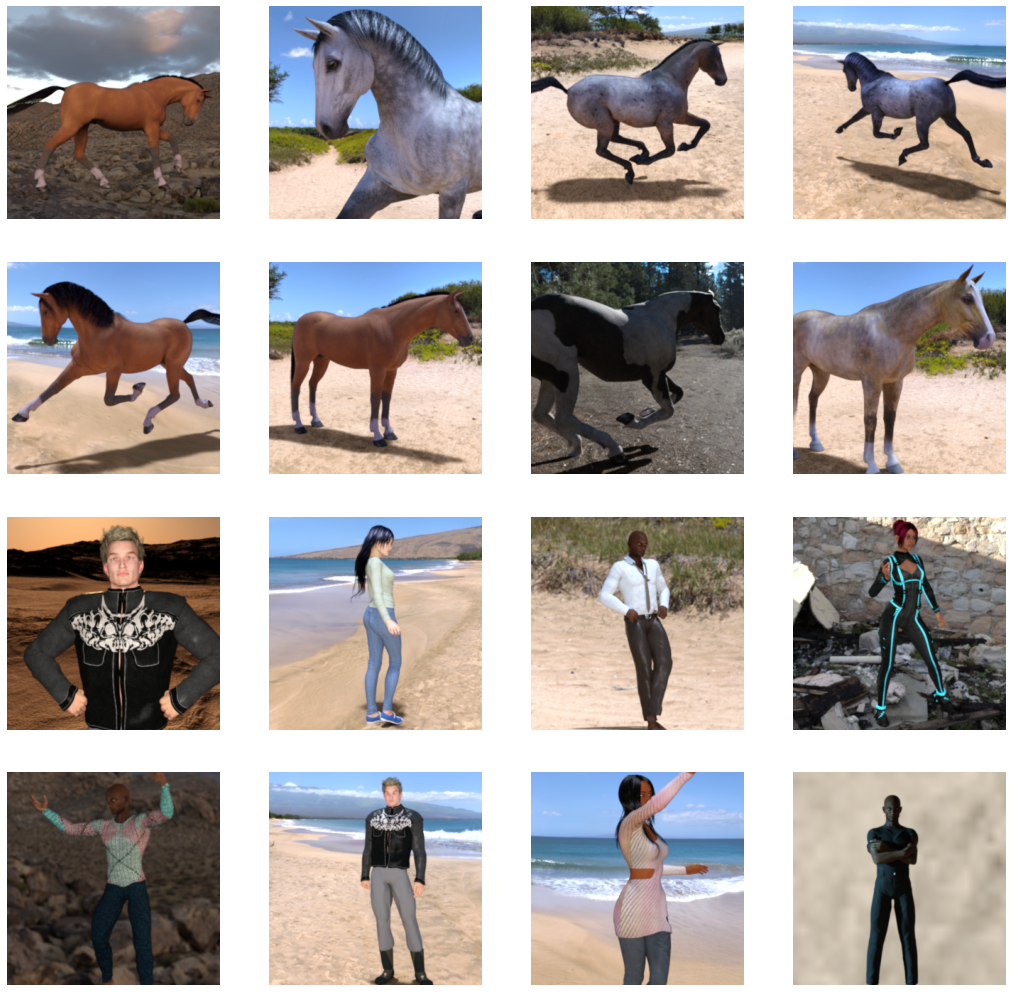

In [ ]:
nrows,ncols = 4,4
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(18,18))
horse_paths = [os.path.join(train_horse_dir,horse_name) for horse_name in horse_names]
human_paths = [os.path.join(train_human_dir,human_name) for human_name in human_names]
for index,path in enumerate(horse_paths + human_paths):
    img = plt.imread(path)
    axes[index // ncols,index % ncols].imshow(img)
    axes[index // ncols,index % ncols].axis('off')

In [ ]:
print(f"shape of image: {img.shape}")

shape of image: (300, 300, 4)


In [ ]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.nn import sigmoid,relu
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop

In [ ]:
model = Sequential([
                    Conv2D(16,(3,3),activation=relu,input_shape=(300,300,3)),
                    MaxPooling2D((2,2)),
                    Conv2D(32,(3,3),activation=relu),
                    MaxPooling2D((2,2)),
                    # Conv2D(64,(3,3),activation=relu),
                    # MaxPooling2D((2,2)),
                    # Conv2D(64,(3,3),activation=relu),
                    # MaxPooling2D((2,2)),
                    Flatten(),
                    Dense(512,activation=relu),
                    Dense(1,activation=sigmoid)
                    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 170528)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               87310848  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('accuracy') > 0.95:
            print("Accuracy > 95% -- Stopping training")
            self.model.stop_training = True

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0)
train_generator = train_datagen.flow_from_directory(directory='/content/horse_or_human',
                                                  target_size=(300,300),
                                                  batch_size=128,
                                                  class_mode='binary')

Found 1027 images belonging to 2 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1/255.0)
val_generator = val_datagen.flow_from_directory(directory='/content/validation',
                                                target_size=(300,300),
                                                batch_size=32,
                                                class_mode='binary')

Found 256 images belonging to 2 classes.


In [ ]:
callbacks = myCallback()
history = model.fit_generator(train_generator,
                              steps_per_epoch=8,  # steps_per_epoch = total examples/batch_size = 1027/128 = 8
                              epochs=3,
                              validation_data=val_generator,
                              validation_steps=8,
                              verbose=1,          # verbose=2 gives less info (animation) while training
                              callbacks=[callbacks])  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
8/8 [==============================] - 10s 972ms/step - loss: 44.0472 - accuracy: 0.5284 - val_loss: 1.0812 - val_accuracy: 0.5000
Epoch 2/3
8/8 [==============================] - 7s 900ms/step - loss: 2.5921 - accuracy: 0.5195 - val_loss: 2.2331 - val_accuracy: 0.5000
Epoch 3/3
8/8 [==============================] - 7s 914ms/step - loss: 0.6447 - accuracy: 0.7375 - val_loss: 5.6189 - val_accuracy: 0.5000


In [ ]:
history.history

{'accuracy': [0.943359375, 0.9977753162384033],
 'loss': [0.13766156136989594, 0.022296221926808357],
 'val_accuracy': [0.73828125, 0.73828125],
 'val_loss': [1.1313376426696777, 1.396535038948059]}

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array,load_img

In [ ]:
model.layers

img is of type <class 'PIL.Image.Image'>, so convert it to array
converting to type <class 'numpy.ndarray'>
shape of image array: (300, 300, 3)
reshaping image array to input shape: (1, 300, 300, 3)


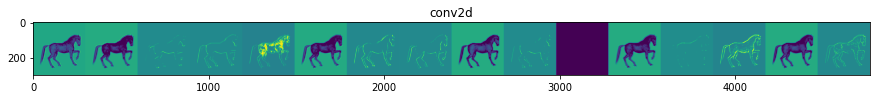

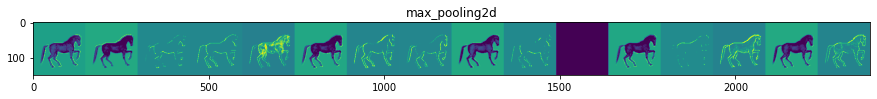

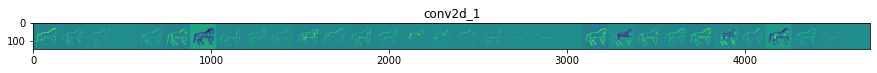

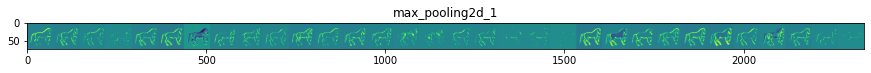

In [ ]:
outputs = [layer.output for layer in model.layers]
names = [layer.name for layer in model.layers]

horses_path = [os.path.join('/content/validation/horses',path) for path in os.listdir('/content/validation/horses')]
humans_path = [os.path.join('/content/validation/humans',path) for path in os.listdir('/content/validation/humans')]
path = np.random.choice(np.concatenate((horses_path,humans_path)))
img = load_img(path)
print("img is of type {}, so convert it to array".format(type(img)))
img_arr = img_to_array(img)
print("converting to type {}".format(type(img_arr)))
print("shape of image array: {}".format(img_arr.shape))
img_arr = np.expand_dims(img_arr,axis=0)
print("reshaping image array to input shape: {}".format(img_arr.shape))
img_arr = img_arr/255.0

visualization_model = Model(inputs=model.input,outputs=outputs)
feature_maps = visualization_model.predict(img_arr)
for name,map in zip(names,feature_maps):
    if len(map.shape) == 4:
        n_features = map.shape[-1]  # number of features/bands in ith feature map
        height_img = map.shape[1]
        width_img = map.shape[2]
        display_grid = np.zeros((height_img,width_img*n_features)).astype(np.uint8)
        for i in range(n_features):
            x = map[0,:,:,i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:,i*width_img:(i+1)*width_img] = x
        plt.figure(figsize=(15,15))
        plt.title(name)
        plt.imshow(display_grid)
        plt.show()

In [ ]:
import signal
os.kill(os.getpid(),signal.SIGKILL)